<div>
  <center>
  <img src="https://drive.google.com/uc?id=1IHXf1W23kjHNsPR4pt61pWa0-43R7BL1" width="400"/>
  </center>
</div>

**Agarwal V, Shendure J**. [Predicting mRNA abundance directly from genomic sequence using deep convolutional neural networks](https://doi.org/10.1101/416685). 2020. *Cell Reports*. [*Github*](https://github.com/vagarwal87/Xpresso). [*Website*](https://xpresso.gs.washington.edu).

# Setup Xpresso dependencies, datasets, and imports


In [ ]:
#Run with Python3/GPU-enabled runtime

#Train/Valid/Test set for predicting median gene expression levels in the human
!wget -r -np -nH --reject "index.html*" --cut-dirs 6 \
 https://krishna.gs.washington.edu/content/members/vagar/Xpresso/data/datasets/pM10Kb_1KTest/
#Train/Valid/Test set for predicting median gene expression levels in the mouse
!wget -r -np -nH --reject "index.html*" --cut-dirs 6 \
 https://krishna.gs.washington.edu/content/members/vagar/Xpresso/data/datasets/pM10Kb_1KTest_Mouse/
#Prepare set of input sequences to generate predictions
!wget https://xpresso.gs.washington.edu/data/Xpresso-predict.zip
!unzip Xpresso-predict.zip

#set up dependencies
!pip install biopython
!pip install hyperopt
%tensorflow_version 1.x

#set up imports
import tensorflow as tf
import sys, gzip, h5py, pickle, os
import numpy as np
import pandas as pd
from mimetypes import guess_type
from Bio import SeqIO
from functools import partial
from scipy import stats
from IPython.display import Image

from tensorflow import keras
from keras.models import Model, load_model
from keras.utils.vis_utils import plot_model
from keras.optimizers import Adam, SGD
from keras.layers import *
from keras.metrics import *
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
from hyperopt import hp, STATUS_OK

print("TF version", tf.__version__)
print("Keras version", keras.__version__)
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

--2021-05-07 15:07:22--  https://krishna.gs.washington.edu/content/members/vagar/Xpresso/data/datasets/pM10Kb_1KTest/
Resolving krishna.gs.washington.edu (krishna.gs.washington.edu)... 128.208.8.136
Connecting to krishna.gs.washington.edu (krishna.gs.washington.edu)|128.208.8.136|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1403 (1.4K) [text/html]
Saving to: ‘pM10Kb_1KTest/index.html.tmp’

pM10Kb_1KTest/index 100%[===================>]   1.37K  --.-KB/s    in 0s      

2021-05-07 15:07:23 (67.0 MB/s) - ‘pM10Kb_1KTest/index.html.tmp’ saved [1403/1403]

Loading robots.txt; please ignore errors.
--2021-05-07 15:07:23--  https://krishna.gs.washington.edu/robots.txt
Reusing existing connection to krishna.gs.washington.edu:443.
HTTP request sent, awaiting response... 404 Not Found
2021-05-07 15:07:23 ERROR 404: Not Found.

Removing pM10Kb_1KTest/index.html.tmp since it should be rejected.

--2021-05-07 15:07:23--  https://krishna.gs.washington.edu/content/members

Using TensorFlow backend.


TF version 1.15.2
Keras version 2.2.4-tf
Found GPU at: /device:GPU:0


# Train Xpresso model for human data

Using best identified hyperparameters from architecture search, these are:
{'datadir': 'pM10Kb_1KTest', 'batchsize': 128, 'leftpos': 3000, 'rightpos': 13500, 'activationFxn': 'relu', 'numFiltersConv1': 128, 'filterLenConv1': 6, 'dilRate1': 1, 'maxPool1': 30, 'numconvlayers': {'numFiltersConv2': 32, 'filterLenConv2': 9, 'dilRate2': 1, 'maxPool2': 10, 'numconvlayers1': {'numconvlayers2': 'two'}}, 'dense1': 64, 'dropout1': 0.00099, 'numdenselayers': {'layers': 'two', 'dense2': 2, 'dropout2': 0.01546}}
Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
promoter (InputLayer)           (None, 10500, 4)     0                                            
__________________________________________________________________________________________________
conv1d_19 (Conv1D)              (None, 10500, 128)   3200        promoter[0][0]   

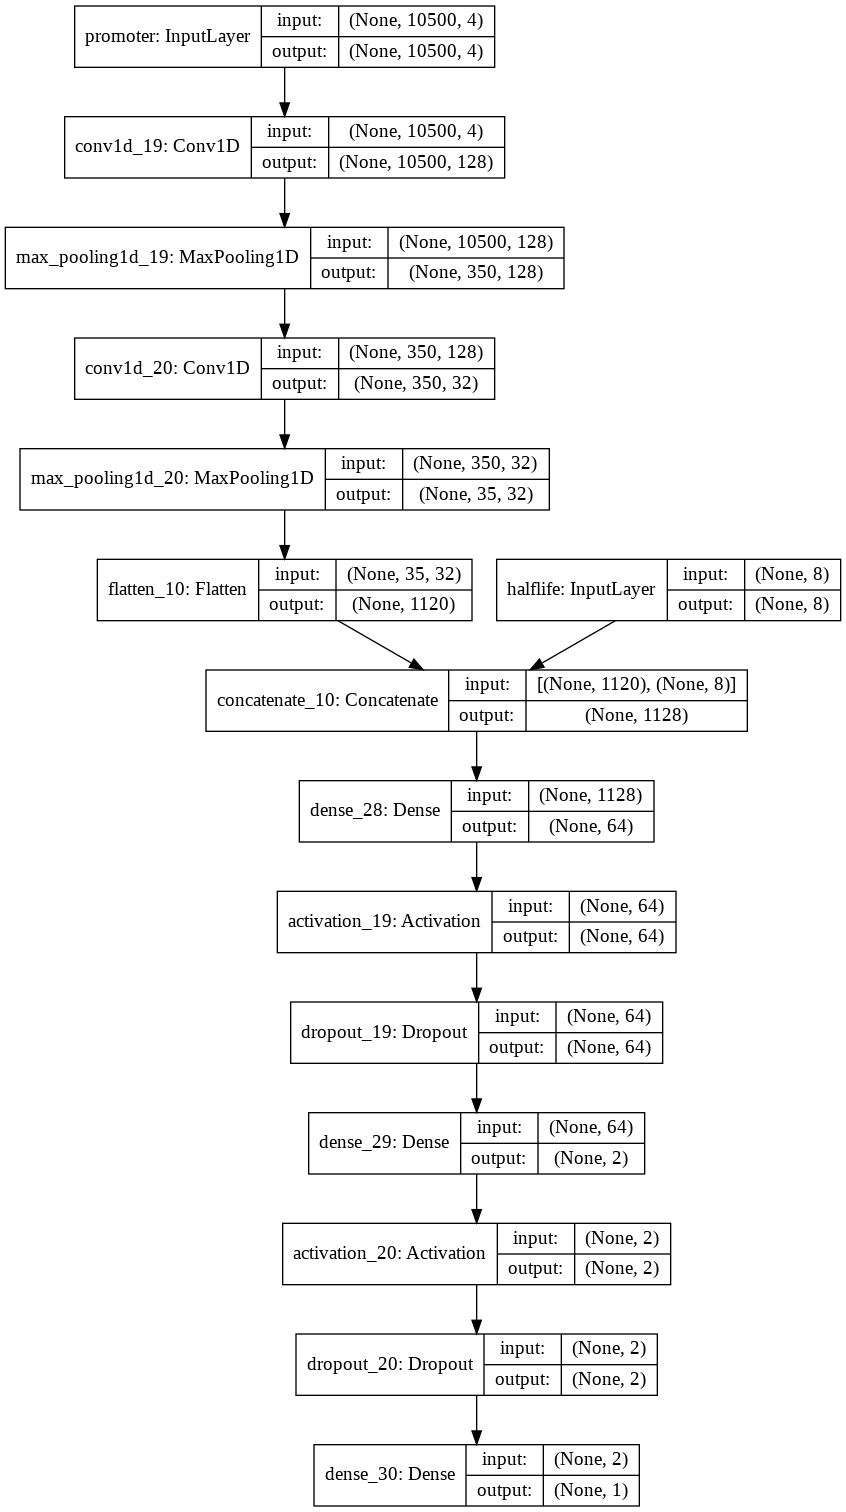

In [ ]:
# Results presented in the paper are the best of 10 independent trials, choosing the one that minimizes
# validation mean squared error loss.
# These results are not exactly those shown in paper due to variability in performance

global X_trainhalflife, X_trainpromoter, y_train, X_validhalflife, X_validpromoter, y_valid, X_testhalflife, X_testpromoter, y_test, geneName_test, params, best_file

def main(datadir):
    global X_trainhalflife, X_trainpromoter, y_train, X_validhalflife, X_validpromoter, y_valid, X_testhalflife, X_testpromoter, y_test, geneName_test, params
    params['datadir'] = datadir
    trainfile = h5py.File(os.path.join(datadir, 'train.h5'), 'r')
    X_trainhalflife, X_trainpromoter, y_train, geneName_train = trainfile['data'], trainfile['promoter'], trainfile['label'], trainfile['geneName']
    validfile = h5py.File(os.path.join(datadir, 'valid.h5'), 'r')
    X_validhalflife, X_validpromoter, y_valid, geneName_valid = validfile['data'], validfile['promoter'], validfile['label'], validfile['geneName']
    testfile = h5py.File(os.path.join(datadir, 'test.h5'), 'r')
    X_testhalflife, X_testpromoter, y_test, geneName_test = testfile['data'], testfile['promoter'], testfile['label'], testfile['geneName']
    #best hyperparams learned
    params = { 'datadir' : datadir, 'batchsize' : 2**7, 'leftpos' : 3000, 'rightpos' : 13500, 'activationFxn' : 'relu', 'numFiltersConv1' : 2**7, 'filterLenConv1' : 6, 'dilRate1' : 1,
                'maxPool1' : 30, 'numconvlayers' : { 'numFiltersConv2' : 2**5, 'filterLenConv2' : 9, 'dilRate2' : 1, 'maxPool2' : 10, 'numconvlayers1' : { 'numconvlayers2' : 'two' } },
                'dense1' : 2**6, 'dropout1' : 0.00099, 'numdenselayers' : { 'layers' : 'two', 'dense2' : 2, 'dropout2' : 0.01546 } }
    print("Using best identified hyperparameters from architecture search, these are:")
    print(params)
    results = objective(params)
    print("Best Validation MSE = %.3f" % results['loss'])

params = {
    'tuneMode' : 1,
    'batchsize' : 2**hp.quniform('batchsize', 5, 7, 1),
    'leftpos' : hp.quniform('leftpos', 0, 10000, 500),
    'rightpos' : hp.quniform('rightpos', 10000, 20000, 500),
    'activationFxn' : 'relu',
    'numFiltersConv1' : 2**hp.quniform('numFiltersConv1', 4, 7, 1),
    'filterLenConv1' : hp.quniform('filterLenConv1', 1, 10, 1),
    'dilRate1' : hp.quniform('dilRate1', 1, 4, 1),
    'maxPool1' : hp.quniform('maxPool1', 5, 100, 5), #5, 100, 5),
    'numconvlayers' : hp.choice('numconvlayers', [
    {
        'numconvlayers1' : 'one'
    },
    {
        'numFiltersConv2' : 2**hp.quniform('numFiltersConv2', 4, 7, 1),
        'filterLenConv2' : hp.quniform('filterLenConv2', 1, 10, 1),
        'dilRate2' : hp.quniform('dilRate2', 1, 4, 1),
        'maxPool2' : hp.quniform('maxPool2', 5, 100, 5),
        'numconvlayers1' : hp.choice('numconvlayers1', [
        {
            'numconvlayers2' : 'two'
        },
        {
            'numFiltersConv3' : 2**hp.quniform('numFiltersConv3', 4, 7, 1),
            'filterLenConv3' : hp.quniform('filterLenConv3', 1, 10, 1),
            'dilRate3' : hp.quniform('dilRate3', 1, 4, 1),
            'maxPool3' : hp.quniform('maxPool3', 5, 100, 5),
            'numconvlayers2' : hp.choice('numconvlayers2', [
            {
                'numconvlayers3' : 'three'
            },
            {
                'numFiltersConv4' : 2**hp.quniform('numFiltersConv4', 4, 7, 1),
                'filterLenConv4' : hp.quniform('filterLenConv4', 1, 10, 1),
                'dilRate4' : hp.quniform('dilRate4', 1, 4, 1),
                'maxPool4' : hp.quniform('maxPool4', 5, 100, 5),
                'numconvlayers3' : 'four'
            }])
        }])
    }]),
    'dense1' : 2**hp.quniform('dense1', 1, 8, 1),
    'dropout1' : hp.uniform('dropout1', 0, 1),
    'numdenselayers' : hp.choice('numdenselayers', [
        {
            'layers' : 'one'
        },
        {
            'layers' : 'two' ,
            'dense2' : 2**hp.quniform('dense2', 1, 8, 1),
            'dropout2' : hp.uniform('dropout2', 0, 1)
        }
    ])
}

def objective(params):
    global best_file
    leftpos = int(params['leftpos'])
    rightpos = int(params['rightpos'])
    activationFxn = params['activationFxn']
    global X_trainhalflife, y_train
    X_trainpromoterSubseq = X_trainpromoter[:,leftpos:rightpos,:]
    X_validpromoterSubseq = X_validpromoter[:,leftpos:rightpos,:]
    halflifedata = Input(shape=(X_trainhalflife.shape[1:]), name='halflife')
    input_promoter = Input(shape=X_trainpromoterSubseq.shape[1:], name='promoter')

    mse = 1
    # defined architecture with best hyperparameters
    x = Conv1D(int(params['numFiltersConv1']), int(params['filterLenConv1']), dilation_rate=int(params['dilRate1']), padding='same', kernel_initializer='glorot_normal', input_shape=X_trainpromoterSubseq.shape[1:],activation=activationFxn)(input_promoter)
    x = MaxPooling1D(int(params['maxPool1']))(x)

    if params['numconvlayers']['numconvlayers1'] != 'one':
        maxPool2 = int(params['numconvlayers']['maxPool2'])
        x = Conv1D(int(params['numconvlayers']['numFiltersConv2']), int(params['numconvlayers']['filterLenConv2']), dilation_rate=int(params['numconvlayers']['dilRate2']), padding='same', kernel_initializer='glorot_normal',activation=activationFxn)(x) #[2, 3, 4, 5, 6, 7, 8, 9, 10]
        x = MaxPooling1D(maxPool2)(x)
        if params['numconvlayers']['numconvlayers1']['numconvlayers2'] != 'two':
            maxPool3 = int(params['numconvlayers']['numconvlayers1']['maxPool3'])
            x = Conv1D(int(params['numconvlayers']['numconvlayers1']['numFiltersConv3']), int(params['numconvlayers']['numconvlayers1']['filterLenConv3']), dilation_rate=int(params['numconvlayers']['numconvlayers1']['dilRate3']), padding='same', kernel_initializer='glorot_normal',activation=activationFxn)(x) #[2, 3, 4, 5]
            x = MaxPooling1D(maxPool3)(x)
            if params['numconvlayers']['numconvlayers1']['numconvlayers2']['numconvlayers3'] != 'three':
                maxPool4 = int(params['numconvlayers']['numconvlayers1']['numconvlayers2']['maxPool4'])
                x = Conv1D(int(params['numconvlayers']['numconvlayers1']['numconvlayers2']['numFiltersConv4']), int(params['numconvlayers']['numconvlayers1']['numconvlayers2']['filterLenConv4']), dilation_rate=int(params['numconvlayers']['numconvlayers1']['numconvlayers2']['dilRate4']), padding='same', kernel_initializer='glorot_normal',activation=activationFxn)(x) #[2, 3, 4, 5]
                x = MaxPooling1D(maxPool4)(x)

    x = Flatten()(x)
    x = Concatenate()([x, halflifedata])
    x = Dense(int(params['dense1']))(x)
    x = Activation(activationFxn)(x)
    x = Dropout(params['dropout1'])(x)
    if params['numdenselayers']['layers'] == 'two':
        x = Dense(int(params['numdenselayers']['dense2']))(x)
        x = Activation(activationFxn)(x)
        x = Dropout(params['numdenselayers']['dropout2'])(x)
    main_output = Dense(1)(x)
    model = Model(inputs=[input_promoter, halflifedata], outputs=[main_output])
    model.compile(SGD(lr=0.0005, momentum=0.9),'mean_squared_error', metrics=['mean_squared_error'])
    # model.compile(Adam(lr=0.0005, beta_1=0.9, beta_2=0.90, epsilon=1e-08, decay=0.0),'mean_squared_error', metrics=['mean_squared_error'])

    print(model.summary())
    modelfile = os.path.join(params['datadir'], 'plotted_model.png')
    plot_model(model, show_shapes=True, show_layer_names=True, to_file=modelfile)

    #train model on training set and eval on 1K validation set
    check_cb = ModelCheckpoint(os.path.join(params['datadir'], 'bestparams.h5'), monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    earlystop_cb = EarlyStopping(monitor='val_loss', patience=7, verbose=1, mode='min')
    result = model.fit([X_trainpromoterSubseq, X_trainhalflife], y_train, batch_size=int(params['batchsize']), shuffle="batch", epochs=100,
        validation_data=[[X_validpromoterSubseq, X_validhalflife], y_valid], callbacks=[earlystop_cb, check_cb])
    mse_history = result.history['val_mean_squared_error']
    mse = min(mse_history)
    
    #evaluate performance on test set using best learned model
    best_file = os.path.join(params['datadir'], 'bestparams.h5')
    model = load_model(best_file)
    print('Loaded results from:', best_file)
    X_testpromoterSubseq = X_testpromoter[:,leftpos:rightpos,:]
    predictions_test = model.predict([X_testpromoterSubseq, X_testhalflife], batch_size=64).flatten()
    slope, intercept, r_value, p_value, std_err = stats.linregress(predictions_test, y_test)
    print('Test R^2 = %.3f' % r_value**2)
    df = pd.DataFrame(np.column_stack((geneName_test, predictions_test, y_test)), columns=['Gene','Pred','Actual'])
    
    print('Rows & Cols:', df.shape)
    df.to_csv(os.path.join(params['datadir'], 'predictions.txt'), index=False, header=True, sep='\t')

    return {'loss': mse, 'status': STATUS_OK }

datadir="pM10Kb_1KTest"
main(datadir=datadir)

#Matches FigS2A
Image(retina=True, filename=os.path.join(datadir, 'plotted_model.png'))

# Generate predictions on a tiled genomic locus or other group of DNA sequences

In [ ]:
def one_hot(seq):
    num_seqs = len(seq)
    seq_len = len(seq[0])
    seqindex = {'A':0, 'C':1, 'G':2, 'T':3, 'a':0, 'c':1, 'g':2, 't':3}
    seq_vec = np.zeros((num_seqs,seq_len,4), dtype='bool')
    
    for i in range(num_seqs):
        thisseq = seq[i]
    
        for j in range(seq_len):
            try:
                seq_vec[i,j,seqindex[thisseq[j]]] = 1
            except:
                pass
    return seq_vec

def generate_predictions(model_file, input_file, output_file):
    model    = load_model(best_file) #or use one of several pre-trained models
    encoding = guess_type(input_file)[1]  # uses file extension to guess zipped or unzipped

    if encoding is None:
        _open = open
    elif encoding == 'gzip':
        _open = partial(gzip.open, mode='rt')
    else:
        raise ValueError('Unknown file encoding: "{}"'.format(encoding))

    i, bs, names, predictions, sequences = 0, 32, [], [], []
    hlfeatures=8
    halflifedata = np.zeros((bs,hlfeatures), dtype='float32')

    with _open(input_file) as f:
        for fasta in SeqIO.parse(f, 'fasta'):
            name, sequence = fasta.id, str(fasta.seq)
            sequences.append(sequence)
            names.append(name)
            i += 1
            if (len(sequence) != 10500):
                sys.exit( "Error in sequence %s, length is not equal to the required 10,500 nts. Please fix or pad with Ns if necessary." % name )
            if i % bs == 0:
                seq = one_hot(sequences)    
                predictions.extend( model.predict([seq, halflifedata], batch_size=bs).flatten().tolist() )
                sequences = []

        remain = i % bs
        if remain > 0:
            halflifedata = np.zeros((remain,hlfeatures), dtype='float32')
            seq = one_hot(sequences)
            predictions.extend( model.predict([seq, halflifedata], batch_size=remain).flatten().tolist() )

        df = pd.DataFrame(np.column_stack((names, predictions)), columns=['ID','SCORE'])
        print(df[1:10]) #print first 10 entries
        df.to_csv(output_file, index=False, header=True, sep='\t')

generate_predictions(model_file="pM10Kb_1KTest/bestparams.h5", 
                     input_file="input_fasta/testinput.fa.gz",
                     output_file="test_predictions.txt")
generate_predictions(model_file="pM10Kb_1KTest/bestparams.h5",
                     input_file="input_fasta/human_promoters.fa.gz",
                     output_file="human_promoter_predictions.txt")

                      ID                SCORE
1  1:109500100-109510600  -1.0694284439086914
2  1:109500200-109510700   -0.984384298324585
3  1:109500300-109510800  -0.9743184447288513
4  1:109500400-109510900  -0.9827132225036621
5  1:109500500-109511000  -0.9246466755867004
6  1:109500600-109511100  -1.0095843076705933
7  1:109500700-109511200  -1.0727555751800537
8  1:109500800-109511300  -1.1254163980484009
9  1:109500900-109511400  -1.0320850610733032
                ID                SCORE
1  ENSG00000000005   -1.125232458114624
2  ENSG00000000419   0.8775529861450195
3  ENSG00000000457   0.5151301622390747
4  ENSG00000000460   0.7985720634460449
5  ENSG00000000938  0.18583348393440247
6  ENSG00000000971  -1.0642242431640625
7  ENSG00000001036  0.08973478525876999
8  ENSG00000001084   0.7877840995788574
9  ENSG00000001167   0.7156234383583069


# Train Xpresso model for mouse data and predict promoters


In [ ]:
main(datadir="pM10Kb_1KTest_Mouse")
generate_predictions(model_file="pM10Kb_1KTest_Mouse/bestparams.h5",
                     input_file="input_fasta/mouse_promoters.fa.gz",
                     output_file="mouse_promoter_predictions.txt")

Using best identified hyperparameters from architecture search, these are:
{'datadir': 'pM10Kb_1KTest_Mouse', 'batchsize': 128, 'leftpos': 3000, 'rightpos': 13500, 'activationFxn': 'relu', 'numFiltersConv1': 128, 'filterLenConv1': 6, 'dilRate1': 1, 'maxPool1': 30, 'numconvlayers': {'numFiltersConv2': 32, 'filterLenConv2': 9, 'dilRate2': 1, 'maxPool2': 10, 'numconvlayers1': {'numconvlayers2': 'two'}}, 'dense1': 64, 'dropout1': 0.00099, 'numdenselayers': {'layers': 'two', 'dense2': 2, 'dropout2': 0.01546}}
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
promoter (InputLayer)           (None, 10500, 4)     0                                            
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 10500, 128)   3200        promoter[0][